# OpenFunctions Test Dataset Exploration

Quick look at the Gorilla OpenFunctions test set: basic stats, tool distribution, and parameter shapes.

In [9]:
import json
import ast
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')

DATA_PATH = Path('../data/gorilla_openfunctions_v1_test.json')


In [10]:
data = json.loads(DATA_PATH.read_text())
print('records:', len(data))
data[:1]


records: 112


[{'question': 'Find a coffee shop near me with free Wi-Fi in San Francisco.',
  'function': {'name': 'Coffee Shop Locator',
   'api_call': 'coffee_shop.find_nearby',
   'description': 'Locate nearby coffee shops based on specific criteria like Wi-Fi availability.',
   'parameters': {'type': 'object',
    'properties': {'location': {'type': 'string',
      'description': 'The city and state, e.g. San Francisco, CA'},
     'amenities': {'type': 'array',
      'items': {'type': 'string',
       'enum': ['Wi-Fi', 'Outdoor Seating', 'Bakery', 'Vegetarian Options']},
      'description': 'Preferred amenities.'}},
    'required': ['location']}},
  'model_answer': 'coffee_shop.find_nearby(location="San Francisco", amenities="Wi-Fi")'}]

In [11]:
first_fn = data[0].get('function', {})
first_fn


{'name': 'Coffee Shop Locator',
 'api_call': 'coffee_shop.find_nearby',
 'description': 'Locate nearby coffee shops based on specific criteria like Wi-Fi availability.',
 'parameters': {'type': 'object',
  'properties': {'location': {'type': 'string',
    'description': 'The city and state, e.g. San Francisco, CA'},
   'amenities': {'type': 'array',
    'items': {'type': 'string',
     'enum': ['Wi-Fi', 'Outdoor Seating', 'Bakery', 'Vegetarian Options']},
    'description': 'Preferred amenities.'}},
  'required': ['location']}}

In [12]:
def parse_function(fn):
    name = fn.get('name', '')
    api = fn.get('api_name') or fn.get('api_call') or ''
    params = fn.get('parameters') or {}
    req = params.get('required') or []
    opt = params.get('optional') or []
    if isinstance(params, dict) and not req and not opt:
        req = []
        for k, v in params.items():
            entry = {'name': k}
            if isinstance(v, dict):
                entry.update({kk: vv for kk, vv in v.items()})
            req.append(entry)
    param_total = len(req) + len(opt)
    return {
        'name': name,
        'api': api,
        'description': fn.get('description', ''),
        'param_required': len(req),
        'param_optional': len(opt),
        'param_total': param_total,
    }

records = []
for row in data:
    fn = row.get('function') or {}
    parsed = parse_function(fn)
    records.append(parsed)
functions_df = pd.DataFrame(records)
functions_df.head()


,name,api,description,param_required,param_optional,param_total
0,Coffee Shop Locator,coffee_shop.find_nearby,Locate nearby coffee shops based on specific c...,1,0,1
1,Flight Booking,flight.book,Book a flight for a specified number of passen...,3,0,3
2,Restaurant Reservation,restaurant.book_table,Reserve a table at a specific restaurant for a...,4,0,4
3,Weather Forecast,weather.forecast,Retrieve a weather forecast for a specific loc...,2,0,2
4,Pharmacy Locator,pharmacy.find_nearby,Locate nearby pharmacies with specific feature...,1,0,1


In [13]:
print('functions parsed:', len(functions_df))
print('unique tools (name, api):', functions_df[['name','api']].drop_duplicates().shape[0])
functions_df[['param_total','param_required','param_optional']].describe()


functions parsed: 112
unique tools (name, api): 109


,param_total,param_required,param_optional
count,112.000000,112.000000,112.0
mean,1.857143,1.857143,0.0
std,0.918843,0.918843,0.0
min,0.000000,0.000000,0.0
25%,1.000000,1.000000,0.0
50%,2.000000,2.000000,0.0
75%,3.000000,3.000000,0.0
max,4.000000,4.000000,0.0


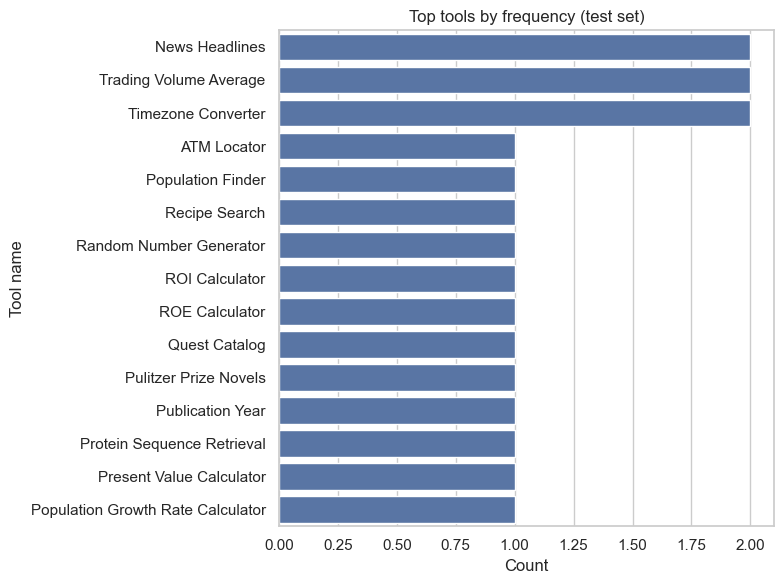

In [14]:
top_tools = (
    functions_df.groupby(['name','api']).size().sort_values(ascending=False).head(15).reset_index(name='count')
)
plt.figure(figsize=(8,6))
sns.barplot(data=top_tools, y='name', x='count')
plt.title('Top tools by frequency (test set)')
plt.xlabel('Count')
plt.ylabel('Tool name')
plt.tight_layout()
plt.show()


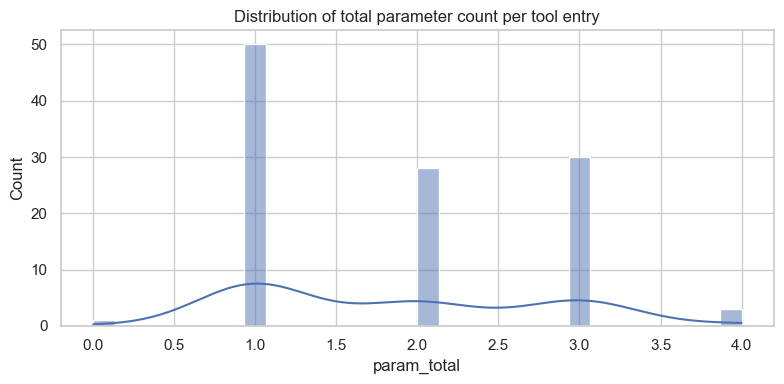

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(functions_df['param_total'], bins=30, kde=True)
plt.title('Distribution of total parameter count per tool entry')
plt.xlabel('param_total')
plt.tight_layout()
plt.show()


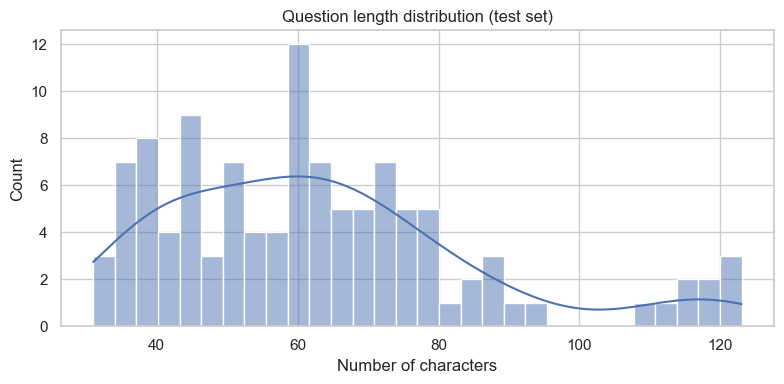

In [16]:
question_lengths = [len(row.get('question','')) for row in data]
plt.figure(figsize=(8,4))
sns.histplot(question_lengths, bins=30, kde=True)
plt.title('Question length distribution (test set)')
plt.xlabel('Number of characters')
plt.tight_layout()
plt.show()
